# Import Library and Install Libraries



In [ ]:
!pip install efficientnet-3D
!pip install keras_applications --no-deps
!pip install keras_preprocessing --no-deps

     |████████████████████████████████| 50 kB 3.2 MB/s 


In [ ]:
import numpy as np
import os
import glob

import pandas as pd
import numpy as np
from pathlib import Path

import random
from tqdm.notebook import tqdm

import cv2  # OpenCV - https://docs.opencv.org/master/d6/d00/tutorial_py_root.html

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import matplotlib.pyplot as plt


# Exatracting and Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/kaggle_competitions/RSNA_MICCAI_Brain_Tumor_Radiogenomic_Classification/12812864_FAIR.zip" "/content/"

In [ ]:
!unzip "/content/12812864_FAIR.zip"

Archive:  /content/12812864_FAIR.zip
  inflating: 128_FLAIR_train_X_3D_64.npy  
  inflating: 128_FLAIR_train_id_3D_64.npy  
  inflating: 128_FLAIR_train_y_3D_64.npy  
  inflating: __results___files/__results___5_1.png  
  inflating: __results___files/__results___8_1.png  


In [ ]:
X_temp = np.load('/content/128_FLAIR_train_X_3D_64.npy',allow_pickle=True)
y_temp = np.load('/content/128_FLAIR_train_y_3D_64.npy', allow_pickle=True)
trainidt = np.load('/content/128_FLAIR_train_id_3D_64.npy', allow_pickle=True)

In [ ]:
len(X_temp), len(y_temp), len(trainidt)

(585, 585, 585)

In [ ]:
X_temp  =list(X_temp)
y_temp = list(y_temp)
trainidt = list(trainidt)

### Remove currupted data

In [ ]:
del X_temp[71]
del X_temp[81]
del X_temp[488]

In [ ]:
del y_temp[71]
del y_temp[81]
del y_temp[488]

In [ ]:
del trainidt[71]
del trainidt[81]
del trainidt[488]

In [ ]:
len(X_temp), len(y_temp), len(trainidt)

(582, 582, 582)

# Split Data into Train and Val set 

In [ ]:
X_train, X_valid, y_train, y_valid, trainidt_train, trainidt_valid = train_test_split(X_temp, y_temp, trainidt, test_size=0.2, random_state=42)

In [ ]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [ ]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)

In [ ]:
X_train.shape, X_valid.shape

((465, 128, 128, 64), (117, 128, 128, 64))

In [ ]:
X_train = np.ndarray.astype(X_train, np.float32)
X_valid = np.ndarray.astype(X_valid, np.float32)

In [ ]:
X_train = tf.expand_dims(X_train, axis=4)
X_valid = tf.expand_dims(X_valid, axis=4)

In [ ]:
X_train.shape, X_valid.shape

(TensorShape([465, 128, 128, 64, 1]), TensorShape([117, 128, 128, 64, 1]))

# Load data in train test loader

In [ ]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)

        return volume/255.0

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    return volume, label


In [ ]:
"""

###################IF we want to repeat 1 D image on 3 channel 

import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)

        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label
""""

In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

batch_size = 1
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_valid))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

# Plot the data

Dimension of the CT scan is: (128, 128, 64, 1)


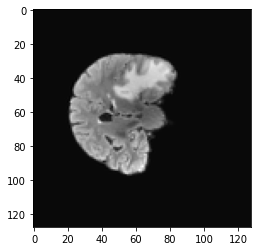

In [ ]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

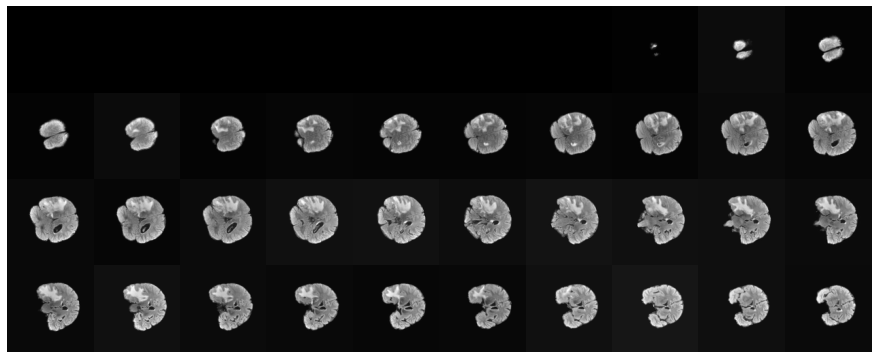

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

# Building Efficientnet 3-D model

### Note - We are using image of shape (224,224,64,1) but pretrained model trained on (None, None, 64,3) so we need to use Conv3D which give filter of output 3 

In [ ]:
# Check the shape required 
inputs = keras.Input(shape=(128,128,64,1))
x = keras.layers.Conv3D(filters=3, kernel_size=3, activation="relu")(inputs)   
shape_model = keras.Model(inputs, x)
shape_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 126, 126, 62, 3)   84        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow.keras as keras 
import os
import efficientnet_3D.tfkeras as efn
# import efficientnet_3D.tfkeras as efn

# Initiating Efficientnet 3D model with pretrained weights 
base_model = efn.EfficientNetB0(input_shape=( 126, 126, 62, 3), weights='imagenet')

# Creating Input layer 
inputs = keras.Input(shape=(128,128,64,1))
# Creating Conv3D model which output 3 filters 
x = keras.layers.Conv3D(filters=3, kernel_size=3, activation="relu")(inputs)   
# Pass the output of Conv3D layer to base model 
x = base_model(x)
# Create Global AveragePooling Layer to make it flat so that it can be passed into Dense layer 
x = tf.keras.layers.GlobalAveragePooling3D(name ="Global_average_pooling_layer")(x)
# Creating Hidden layer
x = keras.layers.Dense(512)(x)
# Create output layer 
outputs = keras.layers.Dense(2, activation="softmax")(x)
# Build model
final_model =  keras.Model(inputs, outputs)

In [ ]:
# model summary
final_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 126, 126, 62, 3)   84        
_________________________________________________________________
efficientnet-b0 (Functional) (None, 4, 4, 2, 1280)     4732124   
_________________________________________________________________
Global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 5,389,106
Trainable params: 5,347,090
Non-trainable params: 42,016
____________________________________________

In [ ]:
# Compiling Model 
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
final_model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/content/weights/3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Start training 

In [ ]:
epochs = 1  # Make it high for good training 
history = final_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    #callbacks=[checkpoint_cb, early_stopping_cb],
)

465/465 - 1562s - loss: 0.7307 - acc: 0.5527 - val_loss: 684578.3750 - val_acc: 0.4530


In [ ]:

# Another model 
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()